# 2018-11-12 Vers le réseau spiking
Maintenant qu'on a validé la selectivité à l'orientation des filtres et qu'ils marchent bien (voir notebook 2018-11-09), j'aimerais vérifier qu'on a bien une Von-Mises dans la selectivité à l'orientation, ça servira de dernière étape de validation pour pouvoir ensuite construire le vrai ring.

### Le firing rate moyen d'un neurone V1 en fonction de l'angle : 40 a pic (Henry et al, 74 ; Dayan Abbot fg 1.5)
TODO aussi : montrer que le petit lag entre orientation et orientation proche produit un décalage temporaire et que ce décalage donne une valeur massivement négative à la STDP donc qui ne peut pas marcher.

### Careful : la tuning curve c'est le firing rate d'une cellule de V1 en fonction des entrées du LGN pour un stim a theta fixe, pas le firing rate d'dune cellule en fonction d'un theta variable dans la stim (mais c'est la même chose)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime

### Unmarkdown either one of the cells below to (1) rerun currents or to (2) load previously generated currents

In [2]:
#Loading MotionClouds
video = np.load('./MotionClouds_64x64x128_24FPS.npy')
print('MotionCloud shape', video.shape)

output_currents = SpiLGN.input_to_currents(video=video, FPS=24., total_time=1000,
                                           distrib_size=10, safeguard_offset=20, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")   
np.savez_compressed('./output/%s'%strtime, output_currents)

MotionCloud shape (64, 64, 128)
Video shape (64, 64, 128)
Frames per second: 24.0
Frame duration at 24.0 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)
Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   26.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   28.9s remaining:   40.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   30.3s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   42.5s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   43.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.7min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  1.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.6min remaining:   52.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.7min finished


In [3]:
load_npz = np.load('./output/%s.npz'%strtime)
load_arr = load_npz['arr_0.npy']

In [4]:
load_arr.shape

(12, 16, 2)

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


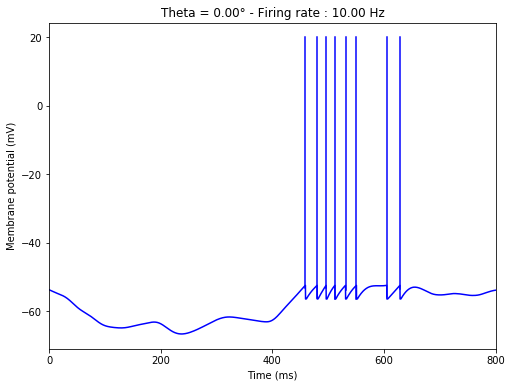

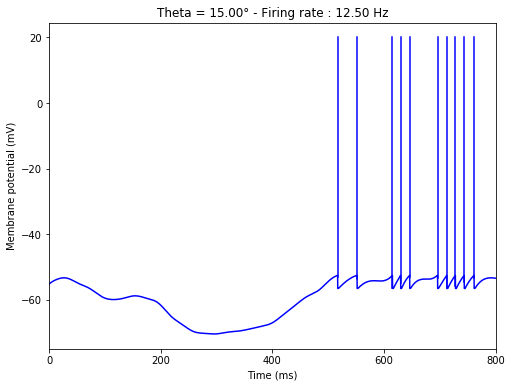

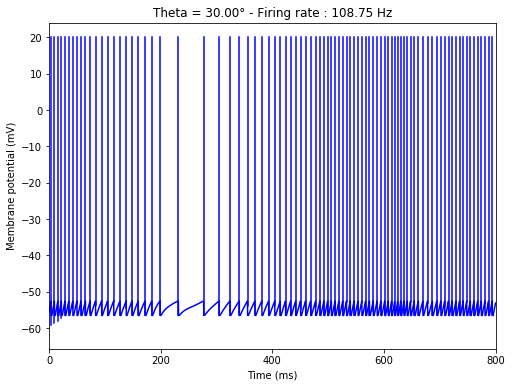

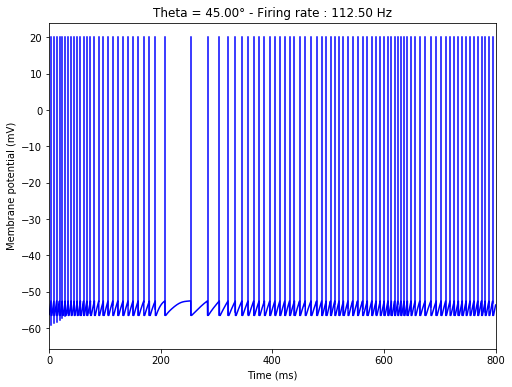

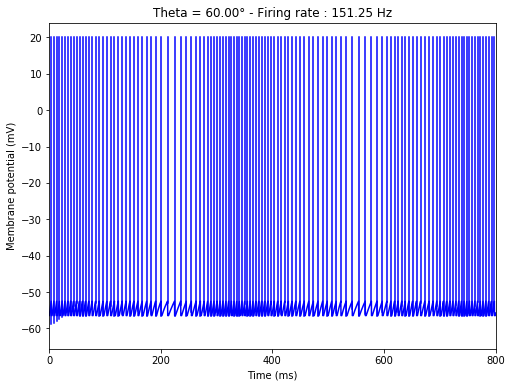

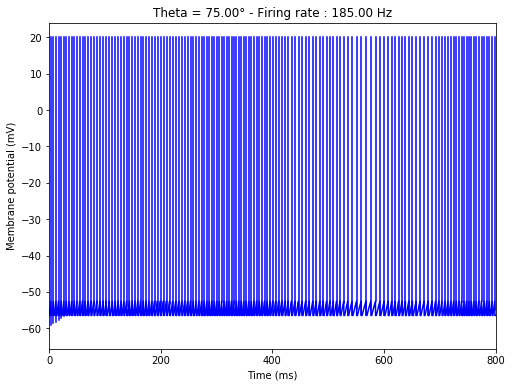

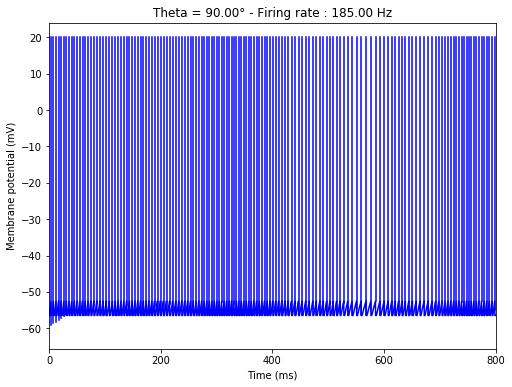

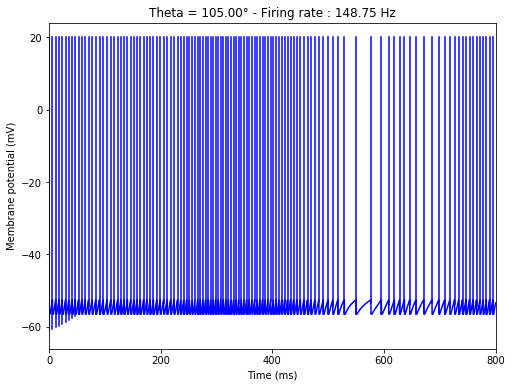

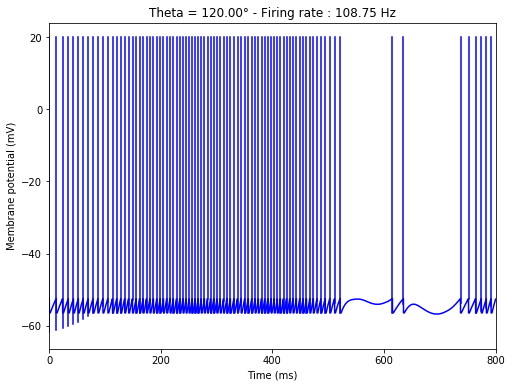

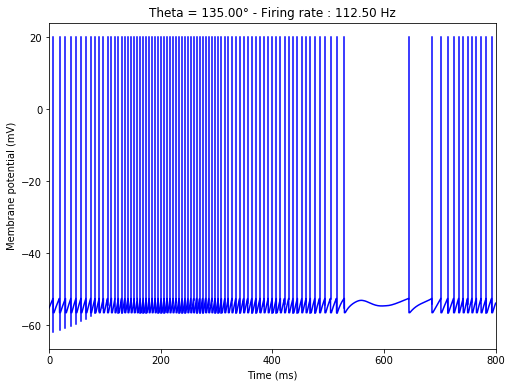

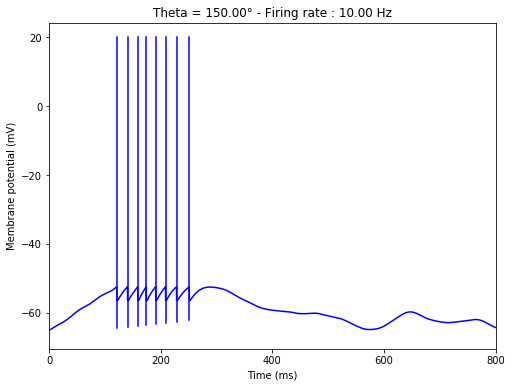

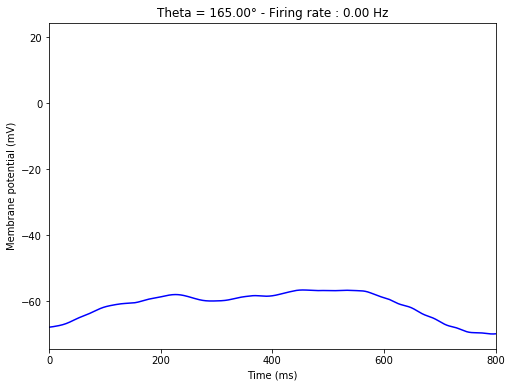

In [5]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

gain = .2
injection_sampling_rate = 1
total_time = len(load_arr[0][0][0][0])

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)

fr_list = []
#we'll loop through 12 thetas but keep the same cell location (gabor : 0)
for theta,_ in enumerate(load_arr) :
    running_theta = theta*(np.pi/12)*180/np.pi
    
    current_levels = load_arr[theta][2] #gabor 0
    
    ##############
    # Simulation #
    ##############
    sim.setup(timestep=0.1)

    post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


    #injecting all ON cells current
    for inputs in range(len(current_levels[0])):

        current_level = current_levels[0][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = current_level*gain)
        current_input.inject_into(post)
        current_input.record()

    #injecting all OFF cells current
    for inputs in range(len(current_levels[1])):

        current_level = current_levels[1][inputs][::injection_sampling_rate]
        current_level = np.asarray(current_level)

        current_input = sim.StepCurrentSource(times = current_times,
                                         amplitudes = -current_level*(gain/2))
        current_input.inject_into(post)
        current_input.record()

    post.record(['spikes', 'v'])

    sim.run(total_time)
    sim.end()

    #PLOTTING and DATA
    post_v = post.get_data().segments[0]
    sig = post_v.analogsignals[0]
    
    plt.figure(figsize = (8,6))
    plt.plot(sig, color = 'b')

    for spikes in np.asarray(post_v.spiketrains[0]):
        plt.plot( [ spikes*10,spikes*10 ] , [sig[int(spikes)] , 20], color = 'b')
        #plt.axvline(spikes*10, ymin = .15, ymax = .9)

    beg = 200 # we have an initialisation firing that causes problems so we remove the first 200 ms

    non_init_times = post_v.spiketrains[0].times > beg
    non_init_spikes = np.asarray(post_v.spiketrains[0])*non_init_times
    non_init_spikes = np.nonzero(non_init_spikes)[0]
    
    fr = non_init_spikes.shape[0]*1000/800
    plt.title('Theta = %.2f° - Firing rate : %.2f Hz' % (running_theta,fr))
    fr_list.append(fr)
              
    plt.xticks([2000, 4000, 6000, 8000, 10000],[0, 200, 400, 600, 800])
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane potential (mV)')

    plt.xlim(beg*10,10000) 

    plt.show()
    plt.pause(.1)


In [6]:
from lmfit.models import GaussianModel
x = np.linspace(0, len(fr_list), len(fr_list))
y = np.asarray(fr_list)

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12
    # variables        = 3
    chi-square         = 5001.38182
    reduced chi-square = 555.709091
    Akaike info crit   = 78.3907544
    Bayesian info crit = 79.8454744
[[Variables]]
    sigma:      2.76111939 +/- 0.23845099 (8.64%) (init = 3.818182)
    center:     5.97027056 +/- 0.23275106 (3.90%) (init = 6)
    amplitude:  1298.39040 +/- 95.5818378 (7.36%) (init = 2119.091)
    fwhm:       6.50193917 +/- 0.56150915 (8.64%) == '2.3548200*sigma'
    height:     187.598861 +/- 13.7270900 (7.32%) == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.592



In [7]:
def fit_curve(xs, sigma, center, amplitude):
    return amplitude/(sigma *np.sqrt(2*np.pi)) * np.exp( (-(xs-center)**2)/ (2*sigma**2)) 

gaussian_distrib = fit_curve(xs=np.linspace(-1, 12, 100),
                             sigma=out.best_values['sigma'],
                             center=out.best_values['center'],
                             amplitude=out.best_values['amplitude'])

Text(0, 0.5, 'Firing rate (Hz)')

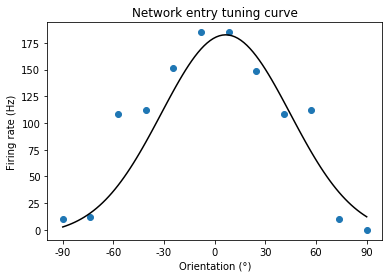

In [8]:
plt.scatter(np.linspace(0, len(fr_list), len(fr_list)),
            fr_list)

plt.plot(np.linspace(0,12,100),gaussian_distrib-5, color = 'black')

plt.xticks([0,2,4,6,8,10,12], [-90, -60, -30, 0, 30, 60, 90])

plt.title('Network entry tuning curve')

plt.xlabel('Orientation (°)')
plt.ylabel('Firing rate (Hz)')
#plt.savefig('./figs/2018_11_14_Tuning_curve.pdf', dpi = 200, format = 'pdf', bbox_inches = 'tight')